In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

ModuleNotFoundError: No module named 'yfinance'

With pandas, it is easy to store, visualize, and perform calculations on your data. With only a few lines of code we can modify our data and present it in an easily-understandable way. Here we simulate some returns in NumPy, put them into a pandas `DataFrame`, and perform calculations to turn them into prices and plot them, all only using a few lines of code.

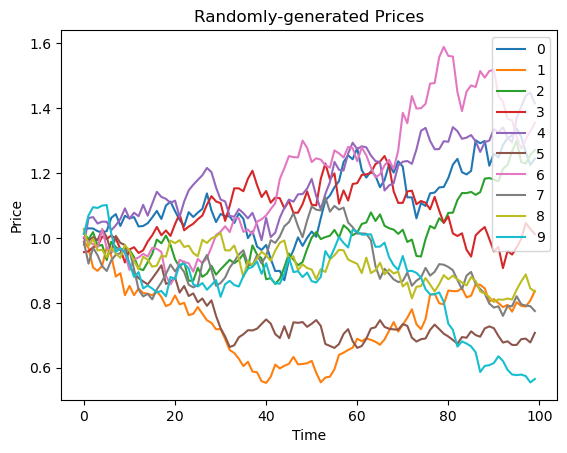

In [5]:
returns = pd.DataFrame(np.random.normal(1.0, 0.03, (100, 10)))
prices = returns.cumprod()
prices.plot()
plt.title('Randomly-generated Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc=0);

So let's have a look at how we actually build up to this point!

## pandas Data Structures

### `Series`

A pandas `Series` is a 1-dimensional array with labels that can contain any data type. We primarily use them for handling time series data. Creating a `Series` is as easy as calling `pandas.Series()` on a Python list or NumPy array.

In [6]:
s = pd.Series([1, 2, np.nan, 4, 5])
print(s)

0    1.0
1    2.0
2    NaN
3    4.0
4    5.0
dtype: float64


Every `Series` has a name. We can give the series a name as a parameter or we can define it afterwards by directly accessing the name attribute. In this case, we have given our time series no name so the attribute should be empty.

In [7]:
print(s.name)

None


This name can be directly modified with no repercussions.

In [8]:
s.name = "Toy Series"
print(s.name)

Toy Series


We call the collected axis labels of a `Series` its index. An index can either passed to a `Series` as a parameter or added later, similarly to its name. In the absence of an index, a `Series` will simply contain an index composed of integers, starting at $0$, as in the case of our "Toy Series".

In [9]:
print(s.index)

RangeIndex(start=0, stop=5, step=1)


pandas has a built-in function specifically for creating date indices, `date_range()`. We use the function here to create a new index for `s`.

In [10]:
new_index = pd.date_range("2016-01-01", periods=len(s), freq="D")
print(new_index)

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05'],
              dtype='datetime64[ns]', freq='D')


An index must be exactly the same length as the `Series` itself. Each index must match one-to-one with each element of the `Series`. Once this is satisfied, we can directly modify the `Series` index, as with the name, to use our new and more informative index (relatively speaking).

In [11]:
s.index = new_index
print(s.index)

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05'],
              dtype='datetime64[ns]', freq='D')


The index of the `Series` is crucial for handling time series, which we will get into a little later.

#### Accessing `Series` Elements

`Series` are typically accessed using the `iloc[]` and `loc[]` methods. We use `iloc[]` to access elements by integer index and we use `loc[]` to access the index of the Series.

In [12]:
print("First element of the series: ", s.iloc[0])
print("Last element of the series: ", s.iloc[len(s)-1])

First element of the series:  1.0
Last element of the series:  5.0


We can slice a `Series` similarly to our favorite collections, Python lists and NumPy arrays. We use the colon operator to indicate the slice.

In [13]:
s.iloc[:2]

2016-01-01    1.0
2016-01-02    2.0
Freq: D, Name: Toy Series, dtype: float64

When creating a slice, we have the options of specifying a beginning, an end, and a step. The slice will begin at the start index, and take steps of size `step` until it passes the end index, not including the end.

In [14]:
start = 0
end = len(s) - 1
step = 1

s.iloc[start:end:step]

2016-01-01    1.0
2016-01-02    2.0
2016-01-03    NaN
2016-01-04    4.0
Freq: D, Name: Toy Series, dtype: float64

We can even reverse a `Series` by specifying a negative step size. Similarly, we can index the start and end with a negative integer value.

In [15]:
s.iloc[::-1]

2016-01-05    5.0
2016-01-04    4.0
2016-01-03    NaN
2016-01-02    2.0
2016-01-01    1.0
Freq: -1D, Name: Toy Series, dtype: float64

This returns a slice of the series that starts from the second to last element and ends at the third to last element (because the fourth to last is not included, taking steps of size $1$).

In [16]:
s.iloc[-2:-4:-1]

2016-01-04    4.0
2016-01-03    NaN
Freq: -1D, Name: Toy Series, dtype: float64

We can also access a series by using the values of its index. Since we indexed `s` with a collection of dates (`Timestamp` objects) we can look at the value contained in `s` for a particular date.

In [17]:
s.loc['2016-01-01']

1.0

Or even for a range of dates!

In [18]:
s.loc['2016-01-02':'2016-01-04']

2016-01-02    2.0
2016-01-03    NaN
2016-01-04    4.0
Freq: D, Name: Toy Series, dtype: float64

With `Series`, we *can* just use the brackets (`[]`) to access elements, but this is not best practice. The brackets are ambiguous because they can be used to access `Series` (and `DataFrames`) using both index and integer values and the results will change based on context (especially with `DataFrames`).

#### Boolean Indexing

In addition to the above-mentioned access methods, you can filter `Series` using boolean arrays. `Series` are compatible with your standard comparators. Once compared with whatever condition you like, you get back yet another `Series`, this time filled with boolean values.

In [19]:
print(s < 3)

2016-01-01     True
2016-01-02     True
2016-01-03    False
2016-01-04    False
2016-01-05    False
Freq: D, Name: Toy Series, dtype: bool


We can pass *this* `Series` back into the original `Series` to filter out only the elements for which our condition is `True`.

In [20]:
print(s.loc[s < 3])

2016-01-01    1.0
2016-01-02    2.0
Freq: D, Name: Toy Series, dtype: float64


If we so desire, we can group multiple conditions together using the logical operators `&`, `|`, and `~` (and, or, and not, respectively).

In [21]:
print(s.loc[(s < 3) & (s > 1)])

2016-01-02    2.0
Freq: D, Name: Toy Series, dtype: float64


This is very convenient for getting only elements of a `Series` that fulfill specific criteria that we need. It gets even more convenient when we are handling `DataFrames`.

#### Indexing and Time Series

Since we use `Series` for handling time series, it's worth covering a little bit of how we handle the time component. For our purposes we use pandas `Timestamp` objects. Let's pull a full time series, complete with all the appropriate labels, by using our `get_pricing()` method. All data pulled with `get_pricing()` or using our Pipeline API will be in either `Series` or `DataFrame` format. We can modify this index however we like.

In [31]:
symbol = "CMG"
start = "2012-01-01"
end = "2016-01-01"
prices = yf.download(symbol, start=start, end=end)['Adj Close']

[*********************100%***********************]  1 of 1 completed


We can display the first few elements of our series by using the `head()` method and specifying the number of elements that we want. The analogous method for the last few elements is `tail()`.

In [32]:
print("\n", type(prices))
prices.head(5) 


 <class 'pandas.core.series.Series'>


Date
2012-01-03    341.269989
2012-01-04    348.750000
2012-01-05    350.480011
2012-01-06    348.950012
2012-01-09    339.739990
Name: Adj Close, dtype: float64

As with our toy example, we can specify a name for our time series, if only to clarify the name the `get_pricing()` provides us.

In [33]:
print('Old name: ', prices.name)
prices.name = symbol
print('New name: ', prices.name)

Old name:  Adj Close
New name:  CMG


Let's take a closer look at the `DatetimeIndex` of our `prices` time series.

In [34]:
print(prices.index)

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06',
               '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               '2012-01-13', '2012-01-17',
               ...
               '2015-12-17', '2015-12-18', '2015-12-21', '2015-12-22',
               '2015-12-23', '2015-12-24', '2015-12-28', '2015-12-29',
               '2015-12-30', '2015-12-31'],
              dtype='datetime64[ns]', name='Date', length=1006, freq=None)


Notice that this `DatetimeIndex` has a collection of associated information. In particular it has an associated frequency (`freq`) and an associated timezone (`tz`). The frequency indicates whether the data is daily vs monthly vs some other period while the timezone indicates what locale this index is relative to. We can modify all of this extra information!

We can also adjust the timezone of a `Series` to adapt the time of real-world data. In our case, our time series is already localized to UTC, but let's say that we want to adjust the time to be 'US/Eastern'. In this case we use the `tz_convert()` method, since the time is already localized.

In [49]:
eastern_prices = prices.tz_localize('US/Eastern')
eastern_prices.head(10)

Date
2012-01-03 00:00:00-05:00    341.269989
2012-01-04 00:00:00-05:00    348.750000
2012-01-05 00:00:00-05:00    350.480011
2012-01-06 00:00:00-05:00    348.950012
2012-01-09 00:00:00-05:00    339.739990
2012-01-10 00:00:00-05:00    341.119995
2012-01-11 00:00:00-05:00    347.600006
2012-01-12 00:00:00-05:00    347.619995
2012-01-13 00:00:00-05:00    354.619995
2012-01-17 00:00:00-05:00    353.380005
Name: CMG, dtype: float64

In addition to the capacity for timezone and frequency management, each time series has a built-in `reindex()` method that we can use to realign the existing data according to a new set of index labels. If data does not exist for a particular label, the data will be filled with a placeholder value. This is typically `np.nan`, though we can provide a fill method.

The data that we `get_pricing()` only includes market days. But what if we want prices for every single calendar day? This will include holidays and weekends, times when you normally cannot trade equities.  First let's create a new `DatetimeIndex` that contains all that we want.

In [51]:
calendar_dates = pd.date_range(start=start, end=end, freq='D', tz='US/Eastern')
print(calendar_dates)

DatetimeIndex(['2012-01-01 00:00:00-05:00', '2012-01-02 00:00:00-05:00',
               '2012-01-03 00:00:00-05:00', '2012-01-04 00:00:00-05:00',
               '2012-01-05 00:00:00-05:00', '2012-01-06 00:00:00-05:00',
               '2012-01-07 00:00:00-05:00', '2012-01-08 00:00:00-05:00',
               '2012-01-09 00:00:00-05:00', '2012-01-10 00:00:00-05:00',
               ...
               '2015-12-23 00:00:00-05:00', '2015-12-24 00:00:00-05:00',
               '2015-12-25 00:00:00-05:00', '2015-12-26 00:00:00-05:00',
               '2015-12-27 00:00:00-05:00', '2015-12-28 00:00:00-05:00',
               '2015-12-29 00:00:00-05:00', '2015-12-30 00:00:00-05:00',
               '2015-12-31 00:00:00-05:00', '2016-01-01 00:00:00-05:00'],
              dtype='datetime64[ns, US/Eastern]', length=1462, freq='D')


Now let's use this new set of dates to reindex our time series. We tell the function that the fill method that we want is `ffill`. This denotes "forward fill". Any `NaN` values will be filled by the *last value* listed. So the price on the weekend or on a holiday will be listed as the price on the last market day that we know about.

In [53]:
calendar_prices = eastern_prices.reindex(calendar_dates, method='ffill')
calendar_prices.head(15)

2012-01-01 00:00:00-05:00           NaN
2012-01-02 00:00:00-05:00           NaN
2012-01-03 00:00:00-05:00    341.269989
2012-01-04 00:00:00-05:00    348.750000
2012-01-05 00:00:00-05:00    350.480011
2012-01-06 00:00:00-05:00    348.950012
2012-01-07 00:00:00-05:00    348.950012
2012-01-08 00:00:00-05:00    348.950012
2012-01-09 00:00:00-05:00    339.739990
2012-01-10 00:00:00-05:00    341.119995
2012-01-11 00:00:00-05:00    347.600006
2012-01-12 00:00:00-05:00    347.619995
2012-01-13 00:00:00-05:00    354.619995
2012-01-14 00:00:00-05:00    354.619995
2012-01-15 00:00:00-05:00    354.619995
Freq: D, Name: CMG, dtype: float64

You'll notice that we still have a couple of `NaN` values right at the beginning of our time series. This is because the first of January in 2012 was a Sunday and the second was a market holiday! Because these are the earliest data points and we don't have any information from before them, they cannot be forward-filled. We will take care of these `NaN` values in the next section, when we deal with missing data.

#### Missing Data

Whenever we deal with real data, there is a very real possibility of encountering missing values. Real data is riddled with holes and pandas provides us with ways to handle them. Sometimes resampling or reindexing can create `NaN` values. Fortunately, pandas provides us with ways to handle them. We have two primary means of coping with missing data. The first of these is filling in the missing data with  `fillna()`. For example, say that we want to fill in the missing days with the mean price of all days.

In [54]:
meanfilled_prices = calendar_prices.fillna(calendar_prices.mean())
meanfilled_prices.head(10)

2012-01-01 00:00:00-05:00    501.068185
2012-01-02 00:00:00-05:00    501.068185
2012-01-03 00:00:00-05:00    341.269989
2012-01-04 00:00:00-05:00    348.750000
2012-01-05 00:00:00-05:00    350.480011
2012-01-06 00:00:00-05:00    348.950012
2012-01-07 00:00:00-05:00    348.950012
2012-01-08 00:00:00-05:00    348.950012
2012-01-09 00:00:00-05:00    339.739990
2012-01-10 00:00:00-05:00    341.119995
Freq: D, Name: CMG, dtype: float64

Using `fillna()` is fairly easy. It is just a matter of indicating the value that you want to fill the spaces with. Unfortunately, this particular case doesn't make a whole lot of sense, for reasons discussed in the [lecture on stationarity](https://www.quantopian.com/lectures/integration-cointegration-and-stationarity) in the Lecture series. We could fill them with with $0$, simply, but that's similarly uninformative.

Rather than filling in specific values, we can use the `method` parameter, similarly to how the `reindex()` method works. We could use "backward fill", where `NaN`s are filled with the *next* filled value (instead of forward fill's *last* filled value) like so:

In [55]:
bfilled_prices = calendar_prices.fillna(method='bfill')
bfilled_prices.head(10)

2012-01-01 00:00:00-05:00    341.269989
2012-01-02 00:00:00-05:00    341.269989
2012-01-03 00:00:00-05:00    341.269989
2012-01-04 00:00:00-05:00    348.750000
2012-01-05 00:00:00-05:00    350.480011
2012-01-06 00:00:00-05:00    348.950012
2012-01-07 00:00:00-05:00    348.950012
2012-01-08 00:00:00-05:00    348.950012
2012-01-09 00:00:00-05:00    339.739990
2012-01-10 00:00:00-05:00    341.119995
Freq: D, Name: CMG, dtype: float64

But again, this is a bad idea for the same reasons as the previous option. Both of these so-called solutions take into account *future data* that was not available at the time of the data points that we are trying to fill. In the case of using the mean or the median, these summary statistics are calculated by taking into account the entire time series. Backward filling is equivalent to saying that the price of a particular security today, right now, tomorrow's price. This also makes no sense. These two options are both examples of look-ahead bias, using data that would be unknown or unavailable at the desired time, and should be avoided.

Our next option is significantly more appealing. We could simply drop the missing data using the `dropna()` method. This is much better alternative than filling `NaN` values in with arbitrary numbers.

In [56]:
dropped_prices = calendar_prices.dropna()
dropped_prices.head(10)

2012-01-03 00:00:00-05:00    341.269989
2012-01-04 00:00:00-05:00    348.750000
2012-01-05 00:00:00-05:00    350.480011
2012-01-06 00:00:00-05:00    348.950012
2012-01-07 00:00:00-05:00    348.950012
2012-01-08 00:00:00-05:00    348.950012
2012-01-09 00:00:00-05:00    339.739990
2012-01-10 00:00:00-05:00    341.119995
2012-01-11 00:00:00-05:00    347.600006
2012-01-12 00:00:00-05:00    347.619995
Freq: D, Name: CMG, dtype: float64

Now our time series is cleaned for the calendar year, with all of our `NaN` values properly handled. It is time to talk about how to actually do time series analysis with pandas data structures.

#### Time Series Analysis with pandas

Let's do some basic time series analysis on our original prices. Each pandas `Series` has a built-in plotting method.

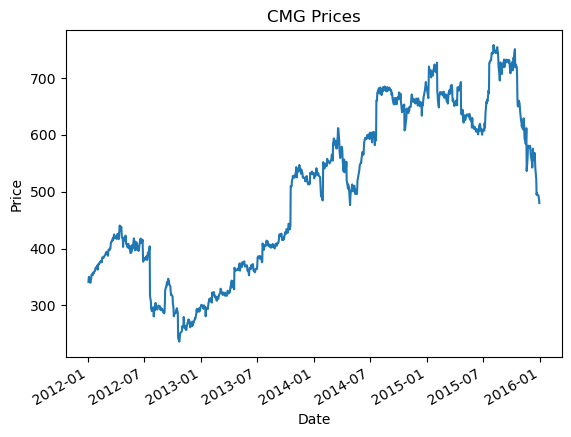

In [57]:
prices.plot();
# We still need to add the axis labels and title ourselves
plt.title(symbol + " Prices")
plt.ylabel("Price")
plt.xlabel("Date");

As well as some built-in descriptive statistics. We can either calculate these individually or using the `describe()` method.

In [58]:
print("Mean: ", prices.mean())
print("Standard deviation: ", prices.std())

Mean:  501.63665038880487
Standard deviation:  146.68873796090145


In [59]:
print("Summary Statistics")
print(prices.describe())

Summary Statistics
count    1006.000000
mean      501.636650
std       146.688738
min       236.240005
25%       371.555000
50%       521.270020
75%       646.834991
max       757.770020
Name: CMG, dtype: float64


We can easily modify `Series` with scalars using our basic mathematical operators.

In [60]:
modified_prices = prices * 2 - 10
modified_prices.head(5)

Date
2012-01-03    672.539978
2012-01-04    687.500000
2012-01-05    690.960022
2012-01-06    687.900024
2012-01-09    669.479980
Name: CMG, dtype: float64

And we can create linear combinations of `Series` themselves using the basic mathematical operators. pandas will group up matching indices and perform the calculations elementwise to produce a new `Series`. 

In [61]:
noisy_prices = prices + 5 * pd.Series(np.random.normal(0, 5, len(prices)), index=prices.index) + 20
noisy_prices.head(5)

Date
2012-01-03    337.774231
2012-01-04    397.376452
2012-01-05    366.775504
2012-01-06    393.701591
2012-01-09    359.511688
dtype: float64

If there are no matching indices, however, we may get an empty `Series` in return.

In [62]:
empty_series = prices + pd.Series(np.random.normal(0, 1, len(prices)))
empty_series.head(5)

2012-01-03 00:00:00   NaN
2012-01-04 00:00:00   NaN
2012-01-05 00:00:00   NaN
2012-01-06 00:00:00   NaN
2012-01-09 00:00:00   NaN
dtype: float64

Rather than looking at a time series itself, we may want to look at its first-order differences or percent change (in order to get additive or multiplicative returns, in our particular case). Both of these are built-in methods.

In [63]:
add_returns = prices.diff()[1:]
mult_returns = prices.pct_change()[1:]

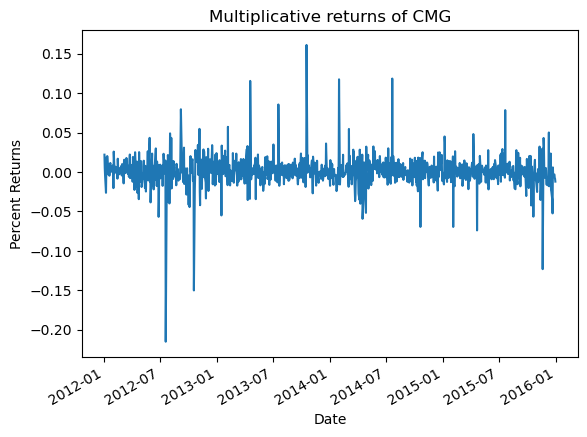

In [64]:
plt.title("Multiplicative returns of " + symbol)
plt.xlabel("Date")
plt.ylabel("Percent Returns")
mult_returns.plot();

pandas has convenient functions for calculating rolling means and standard deviations, as well!

In [67]:
rolling_mean = prices.rolling(30).mean()
rolling_mean.name = "30-day rolling mean"

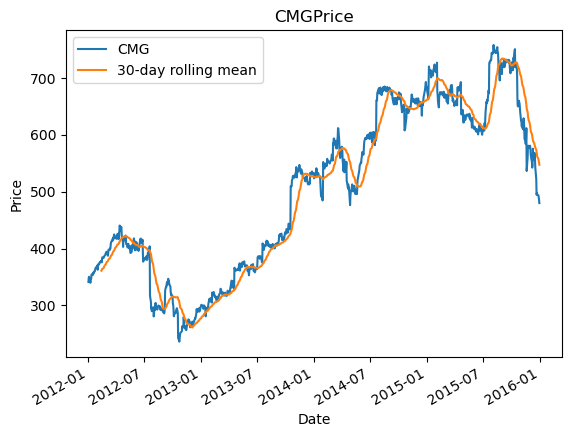

In [68]:
prices.plot()
rolling_mean.plot()
plt.title(symbol + "Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend();

In [70]:
rolling_std = prices.rolling(30).std()
rolling_std.name = "30-day rolling volatility"

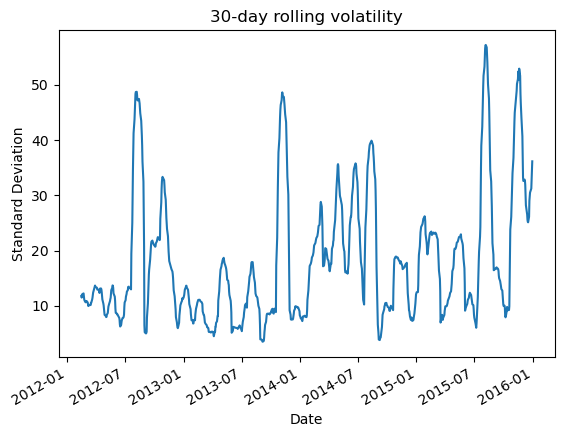

In [71]:
rolling_std.plot()
plt.title(rolling_std.name);
plt.xlabel("Date")
plt.ylabel("Standard Deviation");

Many NumPy functions will work on `Series` the same way that they work on 1-dimensional NumPy arrays.

In [72]:
print(np.median(mult_returns))

0.00023590204910717283


The majority of these functions, however, are already implemented directly as `Series` and `DataFrame` methods.

In [73]:
print(mult_returns.median())

0.00023590204910717283


In every case, using the built-in pandas method will be better than using the NumPy function on a pandas data structure due to improvements in performance. Make sure to check out the `Series` [documentation](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html) before resorting to other calculations of common functions.

### `DataFrames`

Many of the aspects of working with `Series` carry over into `DataFrames`. pandas `DataFrames` allow us to easily manage our data with their intuitive structure. 

Like `Series`, `DataFrames` can hold multiple types of data, but `DataFrames` are 2-dimensional objects, unlike `Series`. Each `DataFrame` has an index and a columns attribute, which we will cover more in-depth when we start actually playing with an object. The index attribute is like the index of a `Series`, though indices in pandas have some extra features that we will unfortunately not be able to cover here. If you are interested in this, check out the [pandas documentation](http://pandas.pydata.org/pandas-docs/version/0.18.1/advanced.html) on advanced indexing. The columns attribute is what provides the second dimension of our `DataFrames`, allowing us to combine named columns (all `Series`), into a cohesive object with the index lined-up.

We can create a `DataFrame` by calling `pandas.DataFrame()` on a dictionary or NumPy `ndarray`. We can also concatenate a group of pandas `Series` into a `DataFrame` using `pandas.concat()`.

In [74]:
dict_data = {
    'a' : [1, 2, 3, 4, 5],
    'b' : ['L', 'K', 'J', 'M', 'Z'],
    'c' : np.random.normal(0, 1, 5)
}
print(dict_data)

{'a': [1, 2, 3, 4, 5], 'b': ['L', 'K', 'J', 'M', 'Z'], 'c': array([-0.7023428 , -2.14609259,  0.28393985,  1.5789248 ,  0.73057585])}


Each `DataFrame` has a few key attributes that we need to keep in mind. The first of these is the index attribute. We can easily include an index of `Timestamp` objects like we did with `Series`.

In [75]:
frame_data = pd.DataFrame(dict_data, index=pd.date_range('2016-01-01', periods=5))
print(frame_data)

            a  b         c
2016-01-01  1  L -0.702343
2016-01-02  2  K -2.146093
2016-01-03  3  J  0.283940
2016-01-04  4  M  1.578925
2016-01-05  5  Z  0.730576


As mentioned above, we can combine `Series` into `DataFrames`. Concatatenating `Series` like this will match elements up based on their corresponding index. As the following `Series` do not have an index assigned, they each default to an integer index. 

In [76]:
s_1 = pd.Series([2, 4, 6, 8, 10], name='Evens')
s_2 = pd.Series([1, 3, 5, 7, 9], name="Odds")
numbers = pd.concat([s_1, s_2], axis=1)
print(numbers)

   Evens  Odds
0      2     1
1      4     3
2      6     5
3      8     7
4     10     9


We will use `pandas.concat()` again later to combine multiple `DataFrame`s into one. 

Each `DataFrame` also has a `columns` attribute. These can either be assigned when we call `pandas.DataFrame` or they can be modified directly like the index. Note that when we concatenated the two `Series` above, the column names were the names of those `Series`.

In [77]:
print(numbers.columns)

Index(['Evens', 'Odds'], dtype='object')


To modify the columns after object creation, we need only do the following:

In [78]:
numbers.columns = ['Shmevens', 'Shmodds']
print(numbers)

   Shmevens  Shmodds
0         2        1
1         4        3
2         6        5
3         8        7
4        10        9


In the same vein, the index of a `DataFrame` can be changed after the fact.

In [79]:
print(numbers.index)

RangeIndex(start=0, stop=5, step=1)


In [80]:
numbers.index = pd.date_range("2016-01-01", periods=len(numbers))
print(numbers)

            Shmevens  Shmodds
2016-01-01         2        1
2016-01-02         4        3
2016-01-03         6        5
2016-01-04         8        7
2016-01-05        10        9


Separate from the columns and index of a `DataFrame`, we can also directly access the values they contain by looking at the values attribute.

In [81]:
numbers.values

array([[ 2,  1],
       [ 4,  3],
       [ 6,  5],
       [ 8,  7],
       [10,  9]])

This returns a NumPy array.

In [82]:
type(numbers.values)

numpy.ndarray

#### Accessing `DataFrame` elements

Again we see a lot of carryover from `Series` in how we access the elements of `DataFrames`. The key sticking point here is that everything has to take into account multiple dimensions now. The main way that this happens is through the access of the columns of a `DataFrame`, either individually or in groups. We can do this either by directly accessing the attributes or by using the methods we already are familiar with.

In [88]:
symbol = ["CMG", "MCD", "SHAK"]
start = "2012-01-01"
end = "2016-01-01"
prices = yf.download(symbol, start=start, end=end)['Adj Close']

[*********************100%***********************]  3 of 3 completed


Here we directly access the `CMG` column. Note that this style of access will only work if your column name has no spaces or unfriendly characters in it.

In [89]:
prices.CMG.head()

Date
2012-01-03    341.269989
2012-01-04    348.750000
2012-01-05    350.480011
2012-01-06    348.950012
2012-01-09    339.739990
Name: CMG, dtype: float64

We can also use `loc[]` to access an individual column like so.

In [90]:
prices.loc[:, 'CMG'].head()

Date
2012-01-03    341.269989
2012-01-04    348.750000
2012-01-05    350.480011
2012-01-06    348.950012
2012-01-09    339.739990
Name: CMG, dtype: float64

Accessing an individual column will return a `Series`, regardless of how we get it.

In [91]:
print(type(prices.CMG))
print(type(prices.loc[:, 'CMG']))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


Notice how we pass a tuple into the `loc[]` method? This is a key difference between accessing a `Series` and accessing a `DataFrame`, grounded in the fact that a `DataFrame` has multiple dimensions. When you pass a 2-dimensional tuple into a `DataFrame`, the first element of the tuple is applied to the rows and the second is applied to the columns. So, to break it down, the above line of code tells the `DataFrame` to return every single row of the column with label `'CMG'`. Lists of columns are also supported.

In [92]:
prices.loc[:, ['CMG', 'MCD']].head()

,CMG,MCD
Date,,
2012-01-03,341.269989,72.811638
2012-01-04,348.750000,73.216812
2012-01-05,350.480011,73.540939
2012-01-06,348.950012,74.108154
2012-01-09,339.739990,73.400970


We can also simply access the `DataFrame` by index value using `loc[]`, as with `Series`.

In [93]:
prices.loc['2015-12-15':'2015-12-22']

,CMG,MCD,SHAK
Date,,,
2015-12-15,554.859985,98.247314,41.580002
2015-12-16,567.830017,99.011902,40.169998
2015-12-17,554.890015,98.726227,38.540001
2015-12-18,541.080017,98.020454,39.750000
2015-12-21,522.010010,98.885872,38.189999
2015-12-22,494.609985,98.911064,39.750000


This plays nicely with lists of columns, too.

In [94]:
prices.loc['2015-12-15':'2015-12-22', ['CMG', 'MCD']]

,CMG,MCD
Date,,
2015-12-15,554.859985,98.247314
2015-12-16,567.830017,99.011902
2015-12-17,554.890015,98.726227
2015-12-18,541.080017,98.020454
2015-12-21,522.010010,98.885872
2015-12-22,494.609985,98.911064


Using `iloc[]` also works similarly, allowing you to access parts of the `DataFrame` by integer index.

In [95]:
prices.iloc[0:2, 1]

Date
2012-01-03    72.811638
2012-01-04    73.216812
Name: MCD, dtype: float64

#### Boolean indexing

As with `Series`, sometimes we want to filter a `DataFrame` according to a set of criteria. We do this by indexing our `DataFrame` with boolean values.

In [100]:
prices.loc[prices.MCD < prices.CMG].head()

,CMG,MCD,SHAK
Date,,,
2012-01-03,341.269989,72.811638,NaN
2012-01-04,348.750000,73.216812,NaN
2012-01-05,350.480011,73.540939,NaN
2012-01-06,348.950012,74.108154,NaN
2012-01-09,339.739990,73.400970,NaN


We can add multiple boolean conditions by using the logical operators `&`, `|`, and `~` (and, or, and not, respectively) again!

In [102]:
prices.loc[(prices.MCD < prices.CMG) & ~prices.SHAK.isnull()].head()

,CMG,MCD,SHAK
Date,,,
2015-01-30,709.840027,75.082291,45.900002
2015-02-02,712.549988,75.139153,43.990002
2015-02-03,726.630005,76.284401,44.980000
2015-02-04,676.000000,76.389977,41.320000
2015-02-05,670.909973,76.625542,42.639999


#### Adding, Removing Columns, Combining `DataFrames`/`Series`

It is all well and good when you already have a `DataFrame` filled with data, but it is also important to be able to add to the data that you have.

We add a new column simply by assigning data to a column that does not already exist. Here we use the `.loc[:, 'COL_NAME']` notation and store the output of `get_pricing()` (which returns a pandas `Series` if we only pass one security) there. This is the method that we would use to add a `Series` to an existing `DataFrame`.

In [104]:
s_1 = yf.download('TSLA', start=start, end=end)['Adj Close']
prices.loc[:, 'TSLA'] = s_1
prices.head(5)

[*********************100%***********************]  1 of 1 completed


,CMG,MCD,SHAK,TSLA
Date,,,,
2012-01-03,341.269989,72.811638,NaN,1.872000
2012-01-04,348.750000,73.216812,NaN,1.847333
2012-01-05,350.480011,73.540939,NaN,1.808000
2012-01-06,348.950012,74.108154,NaN,1.794000
2012-01-09,339.739990,73.400970,NaN,1.816667


It is also just as easy to remove a column.

In [105]:
prices = prices.drop('TSLA', axis=1)
prices.head(5)

,CMG,MCD,SHAK
Date,,,
2012-01-03,341.269989,72.811638,NaN
2012-01-04,348.750000,73.216812,NaN
2012-01-05,350.480011,73.540939,NaN
2012-01-06,348.950012,74.108154,NaN
2012-01-09,339.739990,73.400970,NaN


If we instead want to combine multiple `DataFrame`s into one, we use the `pandas.concat()` method.

In [108]:
df_1 = yf.download(['SPY', '^VIX'], start=start, end=end)['Adj Close']
df_2 = yf.download(['MSFT', 'AAPL', 'GOOG'], start=start, end=end)['Adj Close']
df_3 = pd.concat([df_1, df_2], axis=1)
df_3.head()

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  3 of 3 completed


,SPY,^VIX,AAPL,GOOG,MSFT
Date,,,,,
2012-01-03,104.071907,22.969999,12.519276,16.573130,21.466707
2012-01-04,104.235123,22.219999,12.586559,16.644611,21.971891
2012-01-05,104.512672,21.480000,12.726295,16.413727,22.196428
2012-01-06,104.243317,20.629999,12.859331,16.189817,22.541237
2012-01-09,104.496361,21.070000,12.838936,15.503389,22.244534


#### Missing data (again)
Bringing real-life data into a `DataFrame` brings us the same problems that we had with it in a `Series`, only this time in more dimensions. We have access to the same methods as with `Series`, as demonstrated below.

In [109]:
filled0_prices = prices.fillna(0)
filled0_prices.head(5)

,CMG,MCD,SHAK
Date,,,
2012-01-03,341.269989,72.811638,0.0
2012-01-04,348.750000,73.216812,0.0
2012-01-05,350.480011,73.540939,0.0
2012-01-06,348.950012,74.108154,0.0
2012-01-09,339.739990,73.400970,0.0


In [110]:
bfilled_prices = prices.fillna(method='bfill')
bfilled_prices.head(5)

,CMG,MCD,SHAK
Date,,,
2012-01-03,341.269989,72.811638,45.900002
2012-01-04,348.750000,73.216812,45.900002
2012-01-05,350.480011,73.540939,45.900002
2012-01-06,348.950012,74.108154,45.900002
2012-01-09,339.739990,73.400970,45.900002


But again, the best choice in this case (since we are still using time series data, handling multiple time series at once) is still to simply drop the missing values.

In [111]:
dropped_prices = prices.dropna()
dropped_prices.head(5)

,CMG,MCD,SHAK
Date,,,
2015-01-30,709.840027,75.082291,45.900002
2015-02-02,712.549988,75.139153,43.990002
2015-02-03,726.630005,76.284401,44.980000
2015-02-04,676.000000,76.389977,41.320000
2015-02-05,670.909973,76.625542,42.639999


#### Time Series Analysis with pandas

Using the built-in statistics methods for `DataFrames`, we can perform calculations on multiple time series at once! The code to perform calculations on `DataFrames` here is almost exactly the same as the methods used for `Series` above, so don't worry about re-learning everything.

The `plot()` method makes another appearance here, this time with a built-in legend that corresponds to the names of the columns that you are plotting.

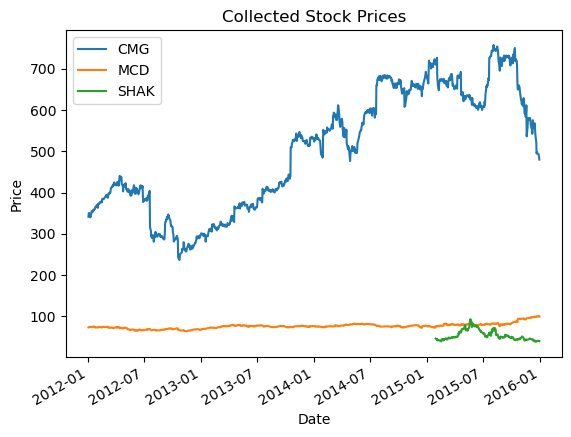

In [112]:
prices.plot()
plt.title("Collected Stock Prices")
plt.ylabel("Price")
plt.xlabel("Date");

The same statistical functions from our interactions with `Series` resurface here with the addition of the `axis` parameter. By specifying the `axis`, we tell pandas to calculate the desired function along either the rows (`axis=0`) or the columns (`axis=1`). We can easily calculate the mean of each columns like so:

In [113]:
prices.mean(axis=0)

CMG     501.636650
MCD      75.984845
SHAK     53.575708
dtype: float64

As well as the standard deviation:

In [114]:
prices.std(axis=0)

CMG     146.688738
MCD       6.445071
SHAK     11.968587
dtype: float64

Again, the `describe()` function will provide us with summary statistics of our data if we would rather have all of our typical statistics in a convenient visual instead of calculating them individually.

In [115]:
prices.describe()

,CMG,MCD,SHAK
count,1006.000000,1006.000000,233.000000
mean,501.636650,75.984845,53.575708
std,146.688738,6.445071,11.968587
min,236.240005,63.334007,38.189999
25%,371.555000,72.954218,44.119999
50%,521.270020,75.672630,49.270000
75%,646.834991,78.950668,61.669998
max,757.770020,100.885597,92.860001


We can scale and add scalars to our `DataFrame`, as you might suspect after dealing with `Series`. This again works element-wise.

In [116]:
(2 * prices - 50).head(5)

,CMG,MCD,SHAK
Date,,,
2012-01-03,632.539978,95.623276,NaN
2012-01-04,647.500000,96.433624,NaN
2012-01-05,650.960022,97.081879,NaN
2012-01-06,647.900024,98.216309,NaN
2012-01-09,629.479980,96.801941,NaN


Here we use the `pct_change()` method to get a `DataFrame` of the multiplicative returns of the securities that we are looking at.

In [117]:
mult_returns = prices.pct_change()[1:]
mult_returns.head()

,CMG,MCD,SHAK
Date,,,
2012-01-04,0.021918,0.005565,NaN
2012-01-05,0.004961,0.004427,NaN
2012-01-06,-0.004365,0.007713,NaN
2012-01-09,-0.026394,-0.009543,NaN
2012-01-10,0.004062,0.000602,NaN


If we use our statistics methods to standardize the returns, a common procedure when examining data, then we can get a better idea of how they all move relative to each other on the same scale.

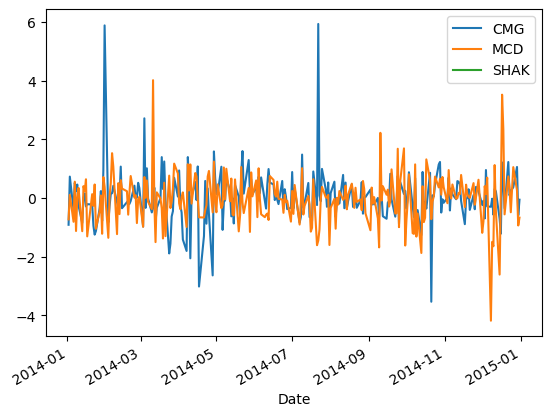

In [118]:
norm_returns = (mult_returns - mult_returns.mean(axis=0))/mult_returns.std(axis=0)
norm_returns.loc['2014-01-01':'2015-01-01'].plot();

This makes it easier to compare the motion of the different time series contained in our example.

Rolling means and standard deviations also work with `DataFrames`.

In [121]:
rolling_mean = prices.rolling(30).mean()
rolling_mean.columns = prices.columns

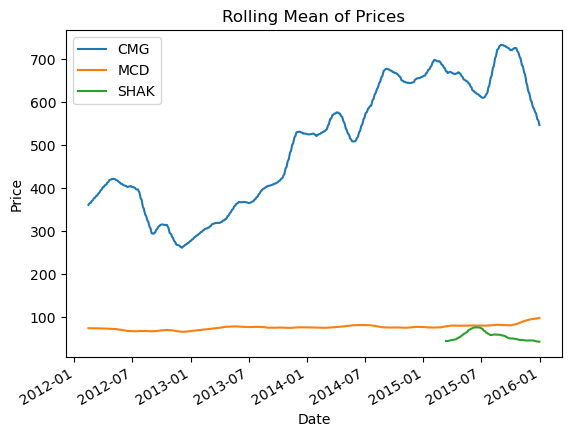

In [122]:
rolling_mean.plot()
plt.title("Rolling Mean of Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend();

For a complete list of all the methods that are built into `DataFrame`s, check out the [documentation](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).